In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/project/3차project/df_v4.csv")
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df

## Image Generator

In [14]:
def generator(df):
  gender = np.array(df.gender)
  age = np.array(df.BA_mean)

  CARPAL_img = [] # 0 : 손목
  TMCP_img = [] # 1 : 엄지 아래
  MMCP_img = [] # 2 : 중지 아래
  LMCP_img = [] # 3 : 새끼 아래
  IP_img = []   # 4 : 엄지 위
  MPIP_img = [] # 5 : 중지 위
  LPIP_img = [] # 6 : 새끼 위

  bimg_in = [] # 원본
  gender_in = []
  age_in = []

  error_list = []

  li = ['CARPAL',	'TMCP',	'MMCP',	'LMCP',	'IP',	'MPIP',	'LPIP']

  for i in range(len(df)):
    # 원본 이미지 경로 가져오기
    file_name = df.loc[i,'img_path']
    # 원본 이미지 읽어오기
    orgin_img = cv2.imread(file_name)
    
    for j in li :
      A = float(df[j][i].strip("'[]").split(',')[0].strip(" ' "))
      B = float(df[j][i].strip("'[]").split(',')[1].strip(" ' "))
      C = float(df[j][i].strip("'[]").split(',')[2].strip(" ' "))
      D = float(df[j][i].strip("'[]").split(',')[3].strip(" ' "))

      x=float(A) * 600
      y=float(B) * 800
      w=float(C) * 600
      h=float(D) * 800
  
      half_width=w/2.0
      half_height=h/2.0
  
      startX=int(x-half_width)
      startY=int(y-half_height)
      endX=int(x+half_width)
      endY=int(y+half_height)

      crop_img = orgin_img[startY:endY,startX:endX]

      if j == 'CARPAL' :
        img_CARPAL = cv2.resize(crop_img, (150, 150),cv2.INTER_AREA)
      elif j == 'TMCP' :
        img_TMCP = cv2.resize(crop_img, (50, 50), cv2.INTER_AREA)
      elif j == 'MMCP' :
        img_MMCP = cv2.resize(crop_img, (50, 50), cv2.INTER_AREA)
      elif j == 'LMCP' :
        img_LMCP = cv2.resize(crop_img, (50, 50), cv2.INTER_AREA)
      elif j == 'IP' :
        img_IP = cv2.resize(crop_img, (50, 50), cv2.INTER_AREA)
      elif j == 'MPIP' :
        img_MPIP = cv2.resize(crop_img, (50, 50), cv2.INTER_AREA)
      elif j == "LPIP" :
        img_LPIP = cv2.resize(crop_img, (50, 50), cv2.INTER_AREA)
      else :
        continue

    # 원본 이미지
    img = cv2.resize(orgin_img, (224, 224),cv2.INTER_AREA)
    bimg_in.append(img)
    # crop img
    CARPAL_img.append(img_CARPAL)
    TMCP_img.append(img_TMCP)
    MMCP_img.append(img_MMCP)
    LMCP_img.append(img_LMCP)
    IP_img.append(img_IP)
    MPIP_img.append(img_MPIP)
    LPIP_img.append(img_LPIP)
    # 성별, 나이
    gender_in.append(gender[i])
    age_in.append(age[i])
  
  # np.array
  # 원본 이미지
  bimg_in = np.array(bimg_in)
  # crop 이미지
  CARPAL_img = np.array(CARPAL_img)
  TMCP_img = np.array(TMCP_img)
  MMCP_img = np.array(MMCP_img)
  LMCP_img = np.array(LMCP_img)
  IP_img = np.array(IP_img)
  MPIP_img = np.array(MPIP_img)
  LPIP_img = np.array(LPIP_img)
  # 성별, 나이
  gender_in = np.array(gender_in)
  age_in = np.array(age_in)
  
  return [bimg_in, CARPAL_img, TMCP_img, MMCP_img, LMCP_img, IP_img, MPIP_img, LPIP_img, gender_in],age_in

In [15]:
train_df, val_df = train_test_split(df, test_size = 0.2, random_state = 0)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_X,train_y = generator(train_df)
val_X,val_y = generator(val_df)

## Model load

In [16]:
import sys

sys.path.append("/content/drive/MyDrive/project/3차project")
print(sys.path)

['/content', '/env/python', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.8/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/project/3차project', '/content/drive/MyDrive/project/3차project']


In [17]:
from TJNet import *

In [25]:
model_name = "tjnet"
model_weight = model_name +"_weight.h5"

model = tjnet()
model.compile(loss ='mse', optimizer= 'nadam', metrics = 'mae' )

## Train

In [26]:
model.fit(train_X,train_y, validation_data = (val_X, val_y), epochs = 1)

31/31 [==============================] - 71s 568ms/step - loss: 2039.4781 - mae: 11.7879 - val_loss: 976.7568 - val_mae: 31.1621


In [27]:
from keras.callbacks import EarlyStopping

epochs = 50
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 10,
                              verbose=0, mode='auto')

rLR = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실을 기준으로 callback 호출
    factor=0.5,          # callback 호출시 학습률을 1/2로
    patience=5,         # 3 epoch 동안 개선되지 않으면 callback 호출
)

callbacks = [early_stopping,rLR]


#fit model
history = model.fit(train_X,train_y,
                    validation_data = (val_X,val_y),
                    epochs = epochs,
                    callbacks= callbacks)

Epoch 1/50
31/31 [==============================] - 16s 512ms/step - loss: 1.7632 - mae: 1.0470 - val_loss: 504.5500 - val_mae: 22.3096 - lr: 0.0010
Epoch 2/50
31/31 [==============================] - 16s 517ms/step - loss: 1.4658 - mae: 0.9698 - val_loss: 213.0322 - val_mae: 14.3937 - lr: 0.0010
Epoch 3/50
31/31 [==============================] - 16s 513ms/step - loss: 1.1934 - mae: 0.8454 - val_loss: 156.0886 - val_mae: 12.2797 - lr: 0.0010
Epoch 4/50
31/31 [==============================] - 16s 506ms/step - loss: 0.5398 - mae: 0.5698 - val_loss: 64.3244 - val_mae: 7.6517 - lr: 0.0010
Epoch 5/50
31/31 [==============================] - 16s 506ms/step - loss: 0.5915 - mae: 0.6288 - val_loss: 24.9310 - val_mae: 4.7268 - lr: 0.0010
Epoch 6/50
31/31 [==============================] - 16s 508ms/step - loss: 0.4146 - mae: 0.5036 - val_loss: 39.2019 - val_mae: 6.0333 - lr: 0.0010
Epoch 7/50
31/31 [==============================] - 16s 509ms/step - loss: 0.4438 - mae: 0.4994 - val_loss: 16.2

In [29]:
# pred = model.predict(val_X)
# print(pred)

mse, mae = model.evaluate(val_X,val_y)
print(mse, mae)

8/8 [==============================] - 1s 122ms/step - loss: 0.3469 - mae: 0.4463
0.34685957431793213 0.44628220796585083


## 시각화

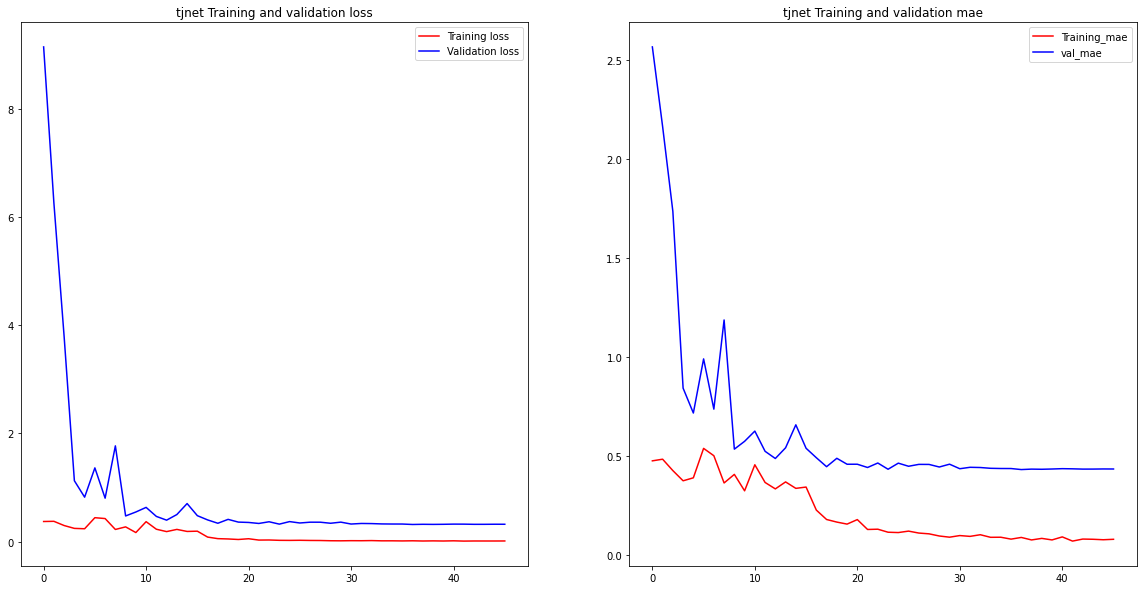

In [24]:
import matplotlib.pyplot as plt

# train 검증의 손실과 정확도 시각화
history = history.history

loss = history['loss']
val_loss = history['val_loss']
mae = history['mae']
val_mae = history['val_mae']

epochs = range(len(loss))

# 한 이미지로 보기 위하여 서브플롯 생성
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()

axs[0].plot(epochs, loss, 'r', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title(model_name+' Training and validation loss')
axs[0].legend(loc=0)

axs[1].plot(epochs, mae, 'r', label='Training_mae')
axs[1].plot(epochs, val_mae, 'b', label='val_mae')
axs[1].set_title(model_name+' Training and validation mae')
axs[1].legend(loc=0)

## 저장

In [ ]:
model.save("/content/drive/MyDrive/project/3차project/4.model_h5_save/"+model_name+"_epoch_50.h5")